<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Yoga-Pose-Comparison/blob/main/Yoga_Asan_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yoga Asan Comparison

This project employs pose estimation and pose similarity comparison in order to detect if the asan being done in 2 given videos given asan video and a reference video) is same or not.   
We also check the asan being done for correctness. By comparing a given video to the reference video we calculate a similarity score for joint movements in the two videos. A threshold can then be set and if value of a joint movement similarity drops below that threshold then the user can be told that there is a problem in his movement of a particular joint during the asan.


### Dataset:
Reference and comparison videos obtained from youtube.
### Steps involved:
1.   Extraction of images from the provided video.  
     *   Capturing images from a given video at regular intervals.
2.   Detection of pose and acquiring keypoints from images in a video.  
     *   Using `tf_pose` to get keypoints from an image.
     *   Converting keypoints obtained to same length (18) by substituting missed keypoints with (0,0).
3.   Similarity Comparison between movement of joints in 2 videos. 
     *   Obtaining joint positions w.r.t. time from the video images keypoints.
     *   Using **'Dynamic Time Warping'** to compare similarity between movement of two joints over time.

## Imports

In [1]:
!pip install tf_pose
!pip install dtaidistance

In [ ]:
import cv2
import matplotlib.pyplot as plt
# import tensorflow as tf
import os
# import sys
# import time
# import logging
import numpy as np
from dtaidistance import dtw, dtw_ndim
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

## Step 1: Extract images from video 
**Warning:** This cell should only be run once to extract images and save to folder on drive.  
*  Extract images between `start_time` and `end_time`.  
*  Set a frame rate to limit the number of images being extracted each second.  

Reference: [Convert Video to Images (Frames) & Images (Frames) to Video using OpenCV (Python)](https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481)

In [ ]:
# Function to extract images from video

def img_from_vid (video_path, image_path, dictionary, frame_rate):
  """
  Reads a given video and saves images from it at a specified frame rate.
  Inputs:
  vid_path: Path where the video is saved
  img_path: The path to save images
  dictionary: `{'<SUBFOLDER>: (<START TIME>, <END TIME>)'}`
              START TIME and END TIME must be in seconds.
              Contains the list of subfolders and the start and end time of the video 
              during which images should be saved into that subfolder. 
              If all images should be saved in a single folder Enter a single name and 
              specify 0 as START TIME and video's length as END TIME
  frame_rate: save `1/frame_rate` images per second
  Outputs: Saves images from the videos to the specified subfolders.
  """
  vid_cap = cv2.VideoCapture(video_path)
  # frame_rate = 0.2 # take `1/frame_rate` images per second
  for name, time in dictionary.items():
    print(f"Starting {name}...")
    
    img_path = image_path + name + "/"
    if not os.path.exists(img_path):
      os.makedirs(img_path)
    current_time, end_time = time
    
    img_count = 1
    
    while(current_time <= end_time):
      
      vid_cap.set(cv2.CAP_PROP_POS_MSEC,current_time*1000)
      ret, img = vid_cap.read()
      if ret == False:
        print("vid_cap.read() didn't return anything.")
        break

      cv2.imwrite(img_path + "image_" + str(img_count) + ".jpg", img)
      
      if(img_count % 50 == 0):
        print(f"Saved {img_count} images.")
        print(f"Current video time: {current_time:.2f}")
      
      img_count += 1
      current_time += frame_rate
    
    print(f"{name} has been completed")
    print("stopped at : ", current_time - frame_rate)
    print(f"saved {img_count - 1} images.")

In [ ]:
# vid_save_path = "/content/drive/MyDrive/Datasets/yoga_supervisor/yoga_videos/random_yoga_1.mp4"
# img_save_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/random_yoga_1/'

surya_namaskar_1_rounds = {'surya_namaskar_1_1_R': (172,221),
                         'surya_namaskar_1_1_L': (221,276),
                         'surya_namaskar_1_2_R': (280,330),
                         'surya_namaskar_1_2_L': (330,384)}

surya_namaskar_2_rounds = {'surya_namaskar_2_1_R': (40,103),
                         'surya_namaskar_2_1_L': (106,148),
                         'surya_namaskar_2_2_R': (154,187),
                         'surya_namaskar_2_2_L': (187,221),
                         'surya_namaskar_2_3_R': (223,256),
                         'surya_namaskar_2_3_L': (257,294),
                         'surya_namaskar_2_4_R': (299,334),
                         'surya_namaskar_2_4_L': (334,373),
                         'surya_namaskar_2_5_R': (380,413),
                         'surya_namaskar_2_5_L': (413,448),
                         'surya_namaskar_2_6_R': (449,484),
                         'surya_namaskar_2_6_L': (485,519)}
random_yoga_1_rounds = { 'random_yoga_1_1': (30, 55),
                         'random_yoga_1_2': (55, 73),
                         'random_yoga_1_3': (73, 90),
                         'random_yoga_1_4': (90, 106)}

In [ ]:
# img_from_vid(vid_save_path, img_save_path, surya_namaskar_1_rounds, 0.2)

## Step 2: Detect pose in image
In order to compare if the asan is being done correctly or not, we first need to detect the keypoints (the joint positions) for each image in the video.

In [ ]:
global_image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/model_image.png'
model='mobilenet_thin'
resize='432x368'
global_image = common.read_imgfile(global_image_path, None, None)
w, h = model_wh(resize)
global_e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
# plt.imshow(global_image)
global_humans = global_e.inference(global_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)


In [ ]:
def show_pose_keypoints(image_path, estimator = global_e, color='orange', show_BG = 'original'):
    """
    takes in image and relative keypoint values and 
    displays image with skeleton and kepoints on it.
    """
    
    image = common.read_imgfile(image_path, None, None)
    humans = estimator.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
    if not humans:
      return (np.zeros((18,2)))
    if show_BG == 'original':
      pass
    elif show_BG == 'black':
      image = np.zeros(image.shape)
    elif show_BG == 'white':
      image = 255*np.ones(image.shape)
    else:
      return "Please enter a valid value for 'show_BG'. 'show_BG' can take following values: 'original','black','white'."
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
    keypoints = str(humans[0]).split('BodyPart:')[1:]
    keypoints_list=[]
    bad_chars = "-( )"
    x = keypoints[0][:-11]
    for i in range (len(keypoints)):
      x = keypoints[i][:-11]
      useful = x.translate(x.maketrans("", "", bad_chars))
      keypt = useful[-9:]
      keypt = tuple(map(float, keypt.split(',')))
      keypoints_list.append(keypt)

    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int)
    keypts_array

    plt.figure(figsize=(10,10))
    plt.axis([0, image.shape[1], 0, image.shape[0]])  
    
    # if show_BG == 'black' or show_BG == 'original':
    #   plt.imshow(image)
    # elif show_BG == 'white':
    #   pass
    plt.imshow(image)
    plt.scatter(*zip(*keypts_array), s=200, color=color, alpha=0.6)
    ax=plt.gca() 
    ax.set_ylim(ax.get_ylim()[::-1]) 
    ax.xaxis.tick_top() 
    plt.title('{} keypoints detected\n'.format(len(keypts_array)))
    plt.grid();
    plt.axis('off')
    for i, txt in enumerate(keypts_array):
        ax.annotate(i, (keypts_array[i][0]-5, keypts_array[i][1]+5))
            
    return keypts_array

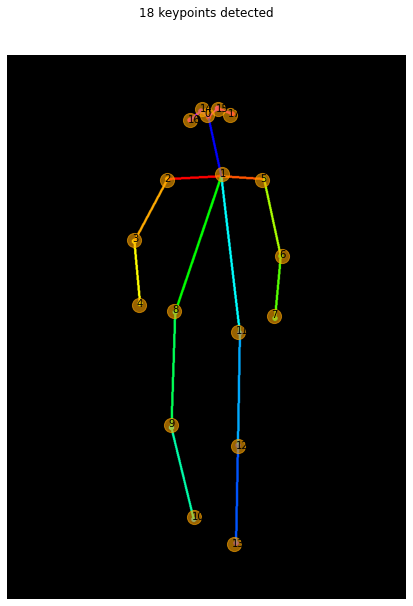

In [ ]:
x = show_pose_keypoints(global_image_path, show_BG = 'black')

### Get Keypoints for the images in the complete video

In [ ]:
surya_namaskar_1_rounds_list = ['surya_namaskar_1_1_R','surya_namaskar_1_1_L','surya_namaskar_1_2_R',
                                'surya_namaskar_1_2_L']

surya_namaskar_2_rounds_list = ['surya_namaskar_2_1_R','surya_namaskar_2_1_L','surya_namaskar_2_2_R',
                                'surya_namaskar_2_2_L','surya_namaskar_2_3_R','surya_namaskar_2_3_L',
                                'surya_namaskar_2_4_R','surya_namaskar_2_4_L','surya_namaskar_2_5_R',
                                'surya_namaskar_2_5_L','surya_namaskar_2_6_R','surya_namaskar_2_6_L']
random_yoga_1_rounds_list = [ 'random_yoga_1_1','random_yoga_1_2','random_yoga_1_3','random_yoga_1_4']

In [ ]:
def save_keypoints_dict(file_path, keypts_dictionary):
  """
  Saves keypoints dictionary to a pickle file.
  Input:
  file_path = file path with extension
  keypts_dictionary: A dictionary with folder name as key and the 
                     keypoints of images inside the folder as its value. 
  Output: save the dictionary to file path
  """
  import pickle
  f = open(file_path,"wb")
  pickle.dump(keypts_dictionary,f)
  f.close()

In [ ]:
def load_keypoints_dict(file_path):
  """
  Takes file path with extension as input and returns the loaded file.
  """
  import pickle
  with open(file_path, 'rb') as f:
      return pickle.load(f)

In [ ]:
def img_keypoints(image, humans):
  """
    Converts relative keypoints received by `estimator.inference()` 
    to 18 absolute key points for the image.
  """

  if not humans:
        return (np.zeros((18,2)))
  keypoints = str(humans[0]).split('BodyPart:')[1:]
  keypoints_list=[]
  bad_chars = "-( )"
  j = 0
  x = keypoints[0][:-11]
  for i in range (18):
    x = keypoints[j][:-11]
    useful = x.translate(x.maketrans("", "", bad_chars))
    k = int(useful[:-9])
    if(i != k):
      keypoints_list.append((0,0))
      continue
    keypt = useful[-9:]
    keypt = tuple(map(float, keypt.split(',')))
    keypoints_list.append(keypt)
    if(j<len(keypoints)-1):
      j+=1

  keypts_array = np.array(keypoints_list)
  keypts_array = keypts_array*(image.shape[1],image.shape[0])
  keypts_array = keypts_array.astype(int)
  keypts_array
  return keypts_array

In [ ]:
def get_keypoints(image_path, estimator):
  """
  Takes image patha nd estimator as input.
  Returns an array with 18 keypoints for all the images in the path passed.
  (Uses the `get_keypoints()` function internally)
  """
  all_keypoints = []
  for image in os.listdir(image_path):
      img = common.read_imgfile(image_path + image, None, None)
      print(image)
      humans_joints = estimator.inference(img,
                          resize_to_default=(w > 0 and h > 0),
                          upsample_size=4.0)
      keypts_array = img_keypoints(img, humans_joints)
      all_keypoints.append(keypts_array)
      if(len(all_keypoints)%50 == 0):
        print(f"Keypoints from {len(all_keypoints)} images loaded.")
  return all_keypoints

In [ ]:
def get_keypoints_dict(asan_folder, subfolder_list):
  """
  Reads images from subfolders in asan folder and 
  returns the keypoints for images inside the subfolders.
  Inputs:
  asan_folder: Path where different rounds of an asan are saved as subfolders.
  subfolder_list: list of subfolders in the asan folder.
              If all images are saved in a single folder Enter a single name pass as a list.
  
  Outputs: the keypoints dictionary for images with key as the subfolder name.
  """
  keypts_dict = {}
  for name in subfolder_list:
    print(name)
    path = asan_folder + name + '/'
    intermediate_keypoints = get_keypoints(path, global_e)
    keypts_dict[name] = np.asarray(intermediate_keypoints)
  return keypts_dict

In [ ]:
# img_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_1/'
# sn1_18_keypts = get_keypoints_dict(img_path, surya_namaskar_1_rounds_list)
# save_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/random_yoga_1_18_keypoints.pkl', sn1_18_keypts)

Using the above functions we can obtain keypoints for images in the full video.  
We now also have a way to make all the keypoints of same length (18) by entering (0,0) for the points that were not identified.    
The next step is to segregate each joint and compare each to corresponding joint from the reference video.   


## Step 3: Similarity Calculation
### Approach Used
Separate all joints from a video:  
Make a list of joint 1 from all images in a video. Similarly for joint 2, 3, ...  
The idea is to:
1.  make a list of a single joint values w.r.t. time and compare it with the reference list of the same joint from the reference video.  
2.  Do this for all joints.  
3.  Get 18 similarity values (1 for the motion of each joint).  

**This method uses motion of each joint through time for comparing similarity rather than position of each joint in image.**

### Separate each joint

In [ ]:
def get_joints_vs_time(vid_images_keypoints, num_joints = 18):
  joints_to_time = {}
  for i in range(num_joints):
    joint = np.array(vid_images_keypoints)[:,i,:]
    joints_to_time['joint_'+str(i)] = joint 
  return joints_to_time

### Calculate and plot similarity between joint movements in 2 videos

In [ ]:
# Similarity function
def get_joint_similarity(my_joint, ref_joint):
  """
  Calculate similarity between movement of two joint 
  Input: reference and current joint keypoints' arrays passed
  Returns similarity percentage.
  """
  norm_1 = np.linalg.norm(my_joint)
  norm_2 = np.linalg.norm(ref_joint)
  normalized_my_joint = my_joint/norm_1
  normalized_ref_joint = ref_joint/norm_2
  
  # Allows comparison even though the length of the arrays passed is different
  similarity = 1 - dtw_ndim.distance(normalized_my_joint, 
                        normalized_ref_joint)
  return similarity


In [ ]:
def plot_joint_similarity(joints_sim):
  """
  takes in the array of similarities in joint movement across two videos.
  draws a line graph of `joints vs similarity`.
  """
  plt.figure(figsize=(12,5))
  num_joints =len(joints_sim)
  min_val = 0
  # Remove nan values before finding min else always nan will be min
  non_nan_joints = joints_sim[~np.isnan(joints_sim)]
  probable_min_val = int(np.min(non_nan_joints))
  if( probable_min_val < 0):
    min_val = probable_min_val - 10
  # max_val = np.max(joints_sim) + 10
  plt.axis([0,num_joints, min_val, 100])
  plt.xlabel('Joint Number (keypoint no.)')
  plt.ylabel('Similarity (%)')
  plt.title('Similarity(%) vs Joint')
  plt.plot(range(0,num_joints), joints_sim, 
           color='green', marker='o', linewidth=2, markersize=10)
  plt.plot(range(0,num_joints),50*np.ones((num_joints)),
           color='red', linestyle='dashed')

In [ ]:
def compare_video_joints(my_vid_joints, ref_vid_joints):
  joint_similarities = []
  for joint_name in my_vid_joints.keys():
    joint_similarity = get_joint_similarity(my_vid_joints[joint_name], ref_vid_joints[joint_name]) 
    joint_similarities.append(np.round(joint_similarity*100,3))

  # nan values might appear in joints similarities if some joint is not detected across the whole video
  joint_similarities = np.array(joint_similarities)
  average_similarity = np.mean(joint_similarities[~np.isnan(joint_similarities)]) # To remove nan values before averaging
  return average_similarity, joint_similarities

## Step 4: Testing

In [ ]:
sn1_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_1_18_keypoints.pkl')
sn2_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_2_18_keypoints.pkl')
sn3_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_3_18_keypoints.pkl')
sn4_full_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_4_full_18_keypoints.pkl')
sn4_half_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/surya_namaskar_4_half_18_keypoints.pkl')
ry1_18_keypoints = load_keypoints_dict('/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/random_yoga_1_18_keypoints.pkl')

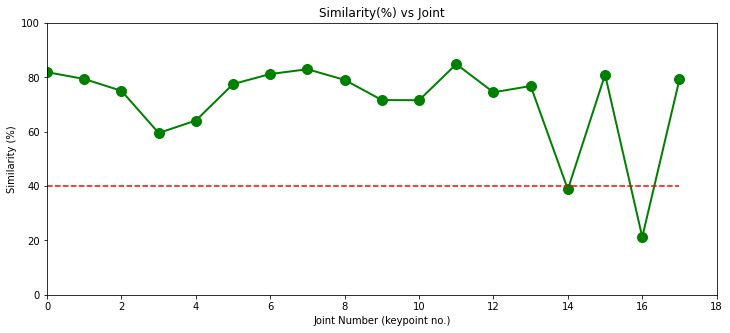

In [ ]:
test_joints_1 = get_joints_vs_time(sn4_full_18_keypoints['surya_namaskar_4_1'])
test_joints_2 = get_joints_vs_time(sn4_full_18_keypoints['surya_namaskar_4_2'])
test_avg, test_sim = compare_video_joints(test_joints_1, test_joints_2)
test_avg, test_sim
plot_joint_similarity(test_sim)

The sharp dip on joint 14 and 16 above is because these joints were identified in very few images

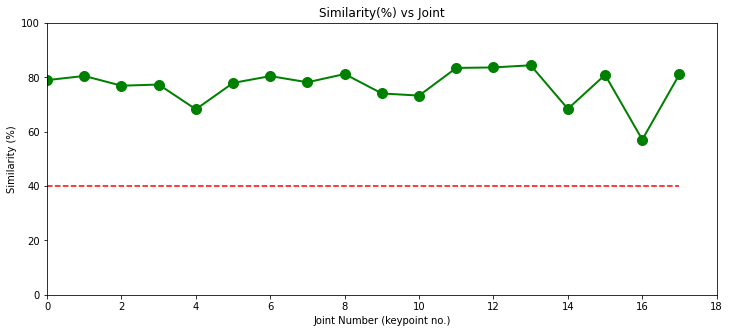

In [ ]:
test_joints_1 = get_joints_vs_time(sn1_18_keypoints['surya_namaskar_1_1_L'])
test_joints_2 = get_joints_vs_time(sn1_18_keypoints['surya_namaskar_1_2_L'])
test_avg, test_sim = compare_video_joints(test_joints_1, test_joints_2)
test_avg, test_sim
plot_joint_similarity(test_sim)

In [ ]:
test_joints_1 = get_joints_vs_time(sn1_18_keypoints['surya_namaskar_1_2_R'])
test_joints_2 = get_joints_vs_time(ry1_18_keypoints['random_yoga_1_2'])
test_avg, test_sim = compare_video_joints(test_joints_1, test_joints_2)
test_avg, test_sim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(7.006352941176471,
 array([  7.57 ,   4.74 ,   7.825,  10.967,  14.795,   5.127,  16.428,
         -3.012,  21.056,   0.587, -25.921,   8.552,  -1.249,     nan,
         13.235,  10.465,  11.454,  16.489]))

**The nan in the similarities above shows that the joint 13 wasn't detected for any of the images in the video.**

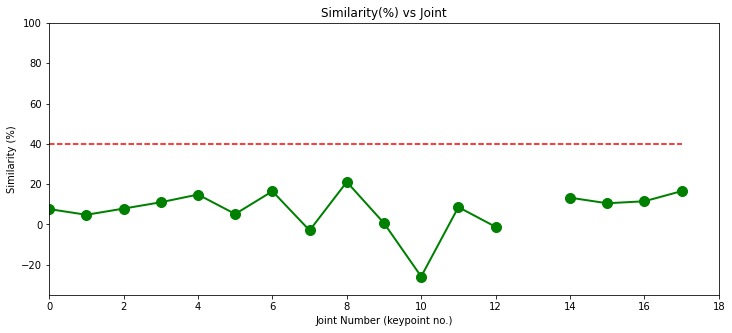

In [ ]:
plot_joint_similarity(test_sim)

In the above graph we can clearly see that when we compare 2 different yogas the difference in joint movements can be clearly seen.  
The gap between joint 12 and 14 is because joint 13 wasn't detected in any of the images.

## Conclusion 
From the above compared examples we can clearly say that our method is successfully showing higher similarity in similar videos and lower similarity in different videos.   

This gives us similarities for each joint w.r.t. time.  
Now we can alert the user when similarity of one of his/her joints is less than a particular threshold to the reference video.  

### Drawbacks/ Challenges


1.   Cannot be used in realtime because:  
      a.  Need the value of joints for a period of time for comparison using Dynamic Time Warping.  
      b.  Getting keypoints from the image is a slow process (<1fps). 


2.   People can be at different locations in the frame but since we are using position of joints to measure similarity/correctness this can affect the similarity value. This effect is undesirable.

        
3.   Need a better way to deal with undetected keypoints. Adding (0,0) adds Noise/bias. (assumes that the missing point didn't have any similarity with any other points)


4.   Pose estimation done using tf_pose library which gives good results but misses out many times. This also leads to dissimilarities that might not be true. Hence, we need a method to ignore these or a better algorithm for pose estimation. Posenet would work but it doesn't have a tf2 implementation.


5.   This method of comparison depends a lot on camera angles. Hence, I want to reduce that dependency too.  

### Possible improvements

Things that can be tried:
1.   We can use Deep Learning based technique to check what is similar and what is different (eg. technique used in face identification)
2.   Use a better algorithm for keypoint detection (Posenet?).
3.   Optimize all steps for better performance.
4.   Try using preprocessing techniques before pose estimation to check if it gives better keypoint detection.
5.   Try using python-dtw library instead of dtaidistance.

**References and some good resources for help with improvements**
*  [Some good implementations of Pose Detection](https://paperswithcode.com/task/keypoint-detection)
*  [Usage explanation for tf_pose](https://towardsdatascience.com/realtime-multiple-person-2d-pose-estimation-using-tensorflow2-x-93e4c156d45f)
*  [Documentation-dtaidistance](https://towardsdatascience.com/realtime-multiple-person-2d-pose-estimation-using-tensorflow2-x-93e4c156d45f)
*  [OpenPose Tutorials](https://www.youtube.com/watch?v=IlsXQPOF9IE&list=PL_Nji0JOuXg24bHB60SB2TwF0PpwhJkCF&index=5)
*  [Great explanation of Human Pose Comparison](https://medium.com/analytics-vidhya/human-pose-comparison-and-action-scoring-using-deep-learning-opencv-python-c2bdf0ddecba)